 **TASK 4**

In [1]:
#Importing required libraries
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

> **DATA LOADING AND PREPROCESSING**

In [2]:
def read_data(filepath):
    df = pd.read_csv(filepath)
    
    return df
    
# Reading the data from HAM_metadata.csv
df = read_data('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')    


The function reads the data and returns a dataframe

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [4]:
df.describe()

,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [5]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [6]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

In [7]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

So far we have taken a look at our dataset and removed null values

In [8]:

import random

    
def show_samples(df, n_samples): 
    fig, axs = plt.subplots(1, n_samples, figsize=(4 * n_samples, 3))
    selected_rows = df.sample(n_samples, random_state=2018)

    for c_ax, (_, c_row) in zip(axs, selected_rows.iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
        c_ax.set_title(c_row['cell_type'])  

    fig.savefig('random_samples.png', dpi=300)

    

The function above shows n number of samples from dataframe.

In [9]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

# Merge images from both folders into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [10]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2


In [11]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((125,100))))

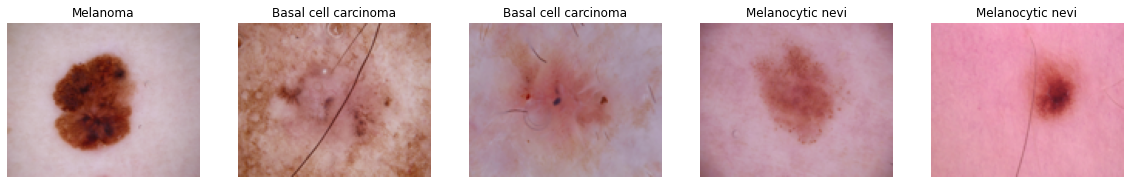

In [12]:
show_samples(df,5)

In [13]:
# See the image size distribution 
df['image'].map(lambda x: x.shape).value_counts()

(100, 125, 3)    10015
Name: image, dtype: int64

In [14]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [15]:
def split_data(df):
    
    features=df.drop(columns=['cell_type_idx'],axis=1)
    target=df['cell_type_idx']
    features.head()
    
    x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=666)
    tf.unique(x_train_o.cell_type.values)
    
    #Data normalization
    x_train = np.asarray(x_train_o['image'].tolist())
    x_test = np.asarray(x_test_o['image'].tolist())

    x_train_mean = np.mean(x_train)
    x_train_std = np.std(x_train)

    x_test_mean = np.mean(x_test)
    x_test_std = np.std(x_test)

    x_train = (x_train - x_train_mean)/x_train_std
    x_test = (x_test - x_test_mean)/x_test_std
    
    # Perform one-hot encoding on the labels
    y_train = to_categorical(y_train_o, num_classes = 7)
    y_test = to_categorical(y_test_o, num_classes = 7)
    y_test
    
    return x_train, x_test, y_train, y_test

The function above divides all data into training and testing data. It performs data normalization on x and one-hot-encoding on y.

In [16]:
x_train, x_test, y_train, y_test = split_data(df)

In [18]:
y_test

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [17]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 999)
# Reshape image in 3 dimensions (height = 100, width = 125 , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(100, 125, 3))
x_test = x_test.reshape(x_test.shape[0], *(100, 125, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(100, 125, 3))

print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)


(6759, 100, 125, 3)
(2504, 100, 125, 3)
(752, 100, 125, 3)


In [18]:
y_train = y_train.reshape(-1, 7)
y_test = y_test.reshape(-1, 7)
y_validate = y_validate.reshape(-1, 7)

x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)
x_validate_flatten = x_validate.reshape(x_validate.shape[0], -1)

print(x_train_flatten.shape)
print(y_train.shape)
print(x_validate_flatten.shape)
print(y_validate.shape)

(6759, 37500)
(6759, 7)
(752, 37500)
(752, 7)


> **ANN CLASSIFICATION**

In [36]:
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


 #Define the optimizer
optimizer = Adam(
    learning_rate=0.00075,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8
)
'''
optimizer = SGD(
    learning_rate=0.00075,  # You can adjust the learning rate as needed
    momentum=0.9,
    nesterov=True
)
'''

'\noptimizer = SGD(\n    learning_rate=0.00075,  # You can adjust the learning rate as needed\n    momentum=0.9,\n    nesterov=True\n)\n'

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=20,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)



# Create the model
model = Sequential()
model.add(Dense(units=80, kernel_initializer='uniform', input_shape=(100 * 125 * 3,)))
model.add(BatchNormalization())  # Batch normalization layer
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(units=80, kernel_initializer='uniform'))
model.add(BatchNormalization())  # Batch normalization layer
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(units=80, kernel_initializer='uniform'))
model.add(BatchNormalization())  # Batch normalization layer
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(units=7, kernel_initializer='uniform', activation='softmax'))

# Compile the keras model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the keras model on the dataset with early stopping
history = model.fit(x_train_flatten, y_train, batch_size=10, epochs=100, validation_data=(x_validate_flatten, y_validate), callbacks=[early_stopping])

accuracy = model.evaluate(x_test_flatten, y_test, verbose=1)[1]
print("Test: accuracy =", accuracy * 100, "%")

Epoch 1/100
676/676 [==============================] - 4s 5ms/step - loss: 1.1410 - accuracy: 0.6225 - val_loss: 0.9474 - val_accuracy: 0.6755
Epoch 2/100
676/676 [==============================] - 3s 4ms/step - loss: 0.8521 - accuracy: 0.6939 - val_loss: 0.8945 - val_accuracy: 0.6835
Epoch 3/100
676/676 [==============================] - 3s 5ms/step - loss: 0.8400 - accuracy: 0.7047 - val_loss: 0.8718 - val_accuracy: 0.6835
Epoch 4/100
676/676 [==============================] - 3s 4ms/step - loss: 0.8074 - accuracy: 0.7105 - val_loss: 0.8414 - val_accuracy: 0.6822
Epoch 5/100
676/676 [==============================] - 3s 4ms/step - loss: 0.7823 - accuracy: 0.7179 - val_loss: 0.8174 - val_accuracy: 0.6955
Epoch 6/100
676/676 [==============================] - 3s 4ms/step - loss: 0.7830 - accuracy: 0.7180 - val_loss: 0.7757 - val_accuracy: 0.6902
Epoch 7/100
676/676 [==============================] - 3s 4ms/step - loss: 0.7369 - accuracy: 0.7299 - val_loss: 0.8375 - val_accuracy: 0.6968

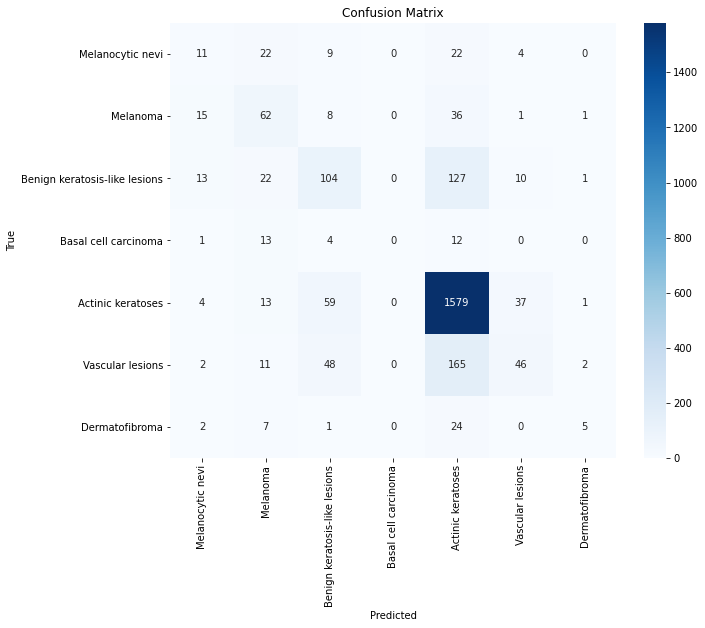

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(x_test_flatten)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)
class_names = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy:", accuracy)

precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Display a classification report
target_names = ['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions', 'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma']
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print(report)

Accuracy: 0.7216453674121406
Precision: 0.6783570712726961
Recall: 0.7216453674121406
F1 Score: 0.6865212660768976
                               precision    recall  f1-score   support

             Melanocytic nevi       0.23      0.16      0.19        68
                     Melanoma       0.41      0.50      0.45       123
Benign keratosis-like lesions       0.45      0.38      0.41       277
         Basal cell carcinoma       0.00      0.00      0.00        30
            Actinic keratoses       0.80      0.93      0.86      1693
             Vascular lesions       0.47      0.17      0.25       274
               Dermatofibroma       0.50      0.13      0.20        39

                     accuracy                           0.72      2504
                    macro avg       0.41      0.32      0.34      2504
                 weighted avg       0.68      0.72      0.69      2504



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
